In [1]:
import torch
import os
import pandas as pd 
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torchvision import transforms,models,utils

In [2]:
test_path=r"D:\xuhaoyan\dogs-vs-cats-redux-kernels-edition\test"
train_path=r"D:\xuhaoyan\dogs-vs-cats-redux-kernels-edition\train"

In [3]:
class catdog_Dataset(Dataset):
    def __init__(self, data_path, train=True, transform=None):
        self.data_path = data_path
        self.train_flag = train
        if transform is None:
            self.transform = transforms.Compose(
            [
                transforms.Resize(size = (224,224)),#尺寸224*224
                transforms.ToTensor(),   #转化为tensor类型
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  #归一化，压缩到合适的区间
            ])
        else:
            self.transform = transform
        self.path_list = os.listdir(data_path)  #listdir返回data_path目录下所有文件的名称，输出为一个列表，文件名称包括后缀！
    def __getitem__(self, idx: int):
        img_path = self.path_list[idx]
        #将训练集的猫狗标签进行编码，狗为1，猫为0
        if self.train_flag is True:
            if img_path.split('.')[0] == 'dog' : 
                label = 1
            else:
                label = 0
        else:
            label = int(img_path.split('.')[0]) # split 的是str类型要转换为int
        label = torch.as_tensor(label, dtype=torch.int64) 
        img_path = os.path.join(self.data_path, img_path) #拼接成每一张图片的路径
        img = Image.open(img_path)   #加载图像jpg类型成为image对象
        img = self.transform(img)
        return img, label   #最终返回tensor类型的img和label
    def __len__(self) -> int:  #返回大小，方便后续划分数据集
        return len(self.path_list)

In [4]:
#测试能否正常迭代
train_1=catdog_Dataset(train_path)
test_1=catdog_Dataset(test_path,train=False)
for i,o in train_1:
    print(i,o)
    break

tensor([[[ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8980,  0.8745],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8980,  0.8824],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.9059,  0.8902],
         ...,
         [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
         [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
         [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

        [[ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5843,  0.5686],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5922,  0.5765],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6078,  0.6000,  0.5843],
         ...,
         [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
         [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

        [[-0.3176, -0.3020, -0.2706,  ..., -0.0588, -0.0431, -0.0510],
         [-0.3176, -0.3020, -0.2706,  ..., -0

划分数据集

In [5]:
t_z=int(0.8*(len(train_1)))
v_z=len(train_1)-t_z
train_80, verification_20 = torch.utils.data.random_split(train_1,[t_z, v_z])

数据迭代器

In [6]:
train_80_loader=torch.utils.data.DataLoader(train_80,batch_size=64,shuffle=True,pin_memory=True)
verification_20_loader=torch.utils.data.DataLoader(verification_20,batch_size=64,shuffle=True,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_1, batch_size=64,
                                            shuffle=True, pin_memory=True)

图像查看

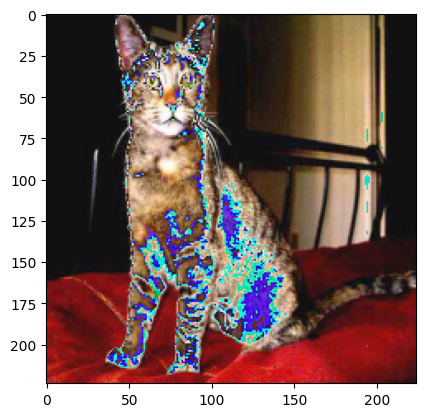

In [7]:
img_PIL_Tensor = train_1[5][0]
new_img_PIL = transforms.ToPILImage()(img_PIL_Tensor).convert('RGB')
plt.imshow(new_img_PIL)
plt.show()

创建模型，卷积神经网络,4层卷积层，3层全连接层

超参数有：卷积核的大小，丢弃层的丢弃率，batch_size

输出高度 = (输入高度 + 上边填充高度 + 下边填充高度 - 卷积核高度) / (步长高度) + 1

输出宽度 = (输入宽度 + 左边填充宽度 + 右边填充宽度 - 卷积核宽度) / (步长宽度) + 1

例如，你的第一层卷积，假设输入是 224 x 224 x 3 的图像，那么输出就是：

(224 + 1 + 1 - 3) / 1 + 1 = 224

(224 + 1 + 1 - 3) / 1 + 1 = 224

所以输出是一个大小为 224 x 224 x 8 的张量。

In [8]:
import torch.nn.functional as F
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,padding=1) #3*3的卷积核
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2,2) # 2*2的池化 
        self.fc1 = nn.Linear(64*14*14,256)#4个池化，所以是224/2/2/2/2=14
        self.fc2 = nn.Linear(256,64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64,2)
    def forward(self,X):
        X=self.pool(F.relu(self.conv1(X)))
        X=self.pool(F.relu(self.conv2(X)))
        X=self.pool(F.relu(self.conv3(X)))
        X=self.pool(F.relu(self.conv4(X)))
        X = X.view(-1, 64*14*14)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)
        X = self.fc3(X)
        return X

损失函数：交叉熵     优化器：自适应随机梯度下降

In [9]:
net=cnn()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

训练过程

In [10]:
history_train_loss=[]
history_train_acc=[]
def train( epoch, train_loader, device, model, criterion, optimizer,):
    total=0
    correct=0
    model = model.to(device)
    for e in range(epoch):
        model.train()
        train_loss = 0.0
        for i, data in enumerate(train_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            # 初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            # 使用torch.topk()函数计算前k个最大值的准确率
            _, predicted = torch.topk(outputs.data, k=2) # 返回前2个最大值和对应索引
            predicted = predicted[:, 0] # 只取第一个最大值作为预测结果
            total += labels.size(0) # 累加总样本数
            correct += (predicted == labels).sum().item() # 累加正确预测数
            train_loss += loss.item()
        history_train_loss.append(train_loss / len(train_loader))
        history_train_acc.append(correct / total)
    print('Finished Training')

定义验证函数，和训练过程基本一致

In [11]:
#可以用来确定超参数，以及判断是否过拟合
history_ver_loss=[]
history_ver_acc=[]
def validate(validate_loader, device, model, criterion):
    correct=0
    total=0
    model = model.to(device)
    model.eval()
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        validate_loader = tqdm(validate_loader)
        validate_loss = 0.0
        for i, data in enumerate(validate_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            #         inputs,labels = data[0],data[1]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _,prec1=torch.topk(outputs.data,k=2) #_赋值的是样本数，被丢弃
            prec1=prec1[:,0]
            total += labels.size(0)
            correct += (prec1 == labels).sum().item()
            validate_loss += loss.item()
        history_ver_loss.append(validate_loss/len(validate_loader))
        history_ver_acc.append(correct/total)
    return history_ver_acc,history_ver_loss

训练

In [12]:
epoch=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train(epoch, train_80_loader, device,net, criterion, optimizer) 

Finished Training


In [13]:
print(history_train_acc,history_train_loss)

[0.62885, 0.6846, 0.7201333333333333, 0.7481375, 0.77225, 0.7944583333333334, 0.8153428571428571, 0.834, 0.8498388888888889, 0.863555] [0.6311457793171794, 0.5211334157104309, 0.4441038985221912, 0.3765096484948271, 0.30100348458503384, 0.2257565017611074, 0.15134769184187577, 0.09411225027550524, 0.06303213282931631, 0.03646076522200716]


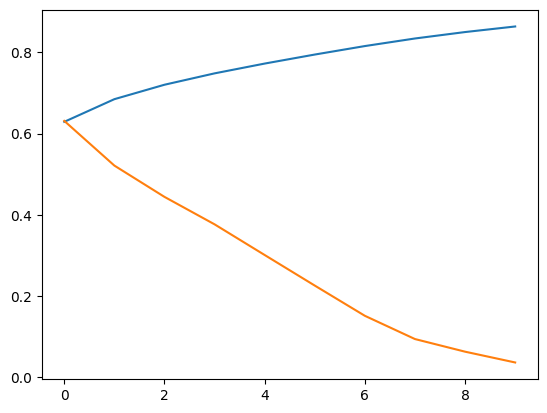

In [14]:
plt.plot(range(epoch),history_train_acc,label="Training Acc")
plt.plot(range(epoch), history_train_loss,label="Training Loss")
plt.show()

验证

In [15]:
list_acc,list_loss=validate(verification_20_loader,device,net,criterion)
print(list_acc,list_loss)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [04:07<00:00,  3.14s/it]

[0.8066] [1.006373777419706]


In [16]:
def submission(csv_path,test_loader, device, model):
    result_list = []
    model = model.to(device)
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            softmax_func = nn.Softmax(dim=1)  # dim=1表示行的和为1 #softmax返回置信度，预测概率
            soft_output = softmax_func(outputs)
            predicted = soft_output[:, 1]
            for i in range(len(predicted)):
                result_list.append({
                    "id": labels[i].item(),
                    "label": predicted[i].item()
                })
    # 从list转成 dataframe 然后保存为csv文件
    columns = result_list[0].keys()
    result_dict = {col: [anno[col] for anno in result_list] for col in columns}
    result_df = pd.DataFrame(result_dict)
    result_df = result_df.sort_values("id")
    result_df.to_csv(csv_path, index=None)

In [17]:
submission('./test.csv',test_loader, device, net)

In [18]:
print(net.parameters)

<bound method Module.parameters of cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)>


In [19]:
print(net.state_dict())

OrderedDict([('conv1.weight', tensor([[[[ 0.0977, -0.1608, -0.1850],
          [ 0.1653,  0.2435,  0.1554],
          [-0.2110,  0.1656,  0.0895]],

         [[ 0.2049,  0.0516, -0.1731],
          [ 0.1822, -0.0231,  0.0546],
          [-0.2332,  0.1492,  0.2168]],

         [[-0.2071, -0.1151, -0.1795],
          [ 0.0790, -0.0727, -0.1916],
          [-0.0940, -0.0860,  0.1415]]],


        [[[-0.2012, -0.0351,  0.0395],
          [-0.0912,  0.1640,  0.0674],
          [-0.1112, -0.2143, -0.1068]],

         [[ 0.0597,  0.2568,  0.2386],
          [-0.1417, -0.0678,  0.1797],
          [-0.1289, -0.0308,  0.0944]],

         [[-0.0730, -0.0220,  0.2382],
          [ 0.0838, -0.1230,  0.0599],
          [-0.2414,  0.0993,  0.1083]]],


        [[[ 0.0784, -0.2191, -0.1291],
          [ 0.0928, -0.0729,  0.1183],
          [ 0.1692, -0.0358,  0.0036]],

         [[ 0.1089, -0.0873,  0.1053],
          [ 0.2620, -0.0646, -0.1529],
          [ 0.1994,  0.1191, -0.0802]],

         [[ 0.